# Содержание

* [1. Изученеие файлов с данными, загрузка библиотек.](#Откройте-и-изучите-файл)
* [2. Разбиение данных на выборки.](#Разбейте-данные-на-выборки)
* [3. Исследование моделей.](#Исследуйте-модели)  
  * [3.1. Decision Tree.](#Decision-Tree)
  * [3.2. Random Forest.](#Random-Forest)
  * [3.3. Logistic Regression.](#Logistic-Regression)
  * [3.4. Вывод.](#Вывод)
* [4. Проверка моделей на тестовой выборке.](#Проверьте-модель-на-тестовой-выборке)
  * [4.1 Вывод.](#Вывод)

# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
271,62.0,509.38,40.0,21096.53,1
2186,173.0,1255.32,17.0,4134.29,1
1414,44.0,287.93,9.0,27093.07,0
1082,81.0,588.15,56.0,19383.95,0
287,4.0,19.33,7.0,3431.02,1


Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Изменим тип у столбцов с количеством сообщений и количеством звонков на целочисленный, так как не может быть дробных сообщений и звонков.

In [3]:
df['messages'] = df['messages'].astype('int')
df['calls'] = df['calls'].astype('int')

Проверим данные на дубликаты.

In [4]:
df.duplicated().sum()

0

Дубликатов нет.

Посмотрим на мультиколлинеарность факторов. Построим графики зависимостей между факторами. 

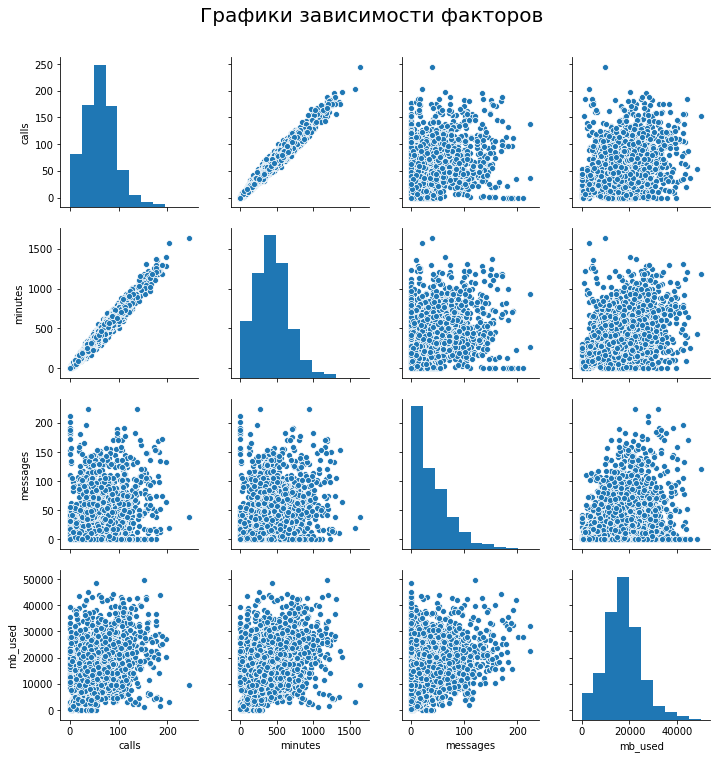

In [5]:
g = sns.pairplot(df[['calls', 'minutes', 'messages', 'mb_used']])
g.fig.suptitle("Графики зависимости факторов", y=1.05, size=20)
plt.show()

Есть мультиколлинеарность у количества звонков и количества минут. В дальнейшем уберём количество звнков из модели.

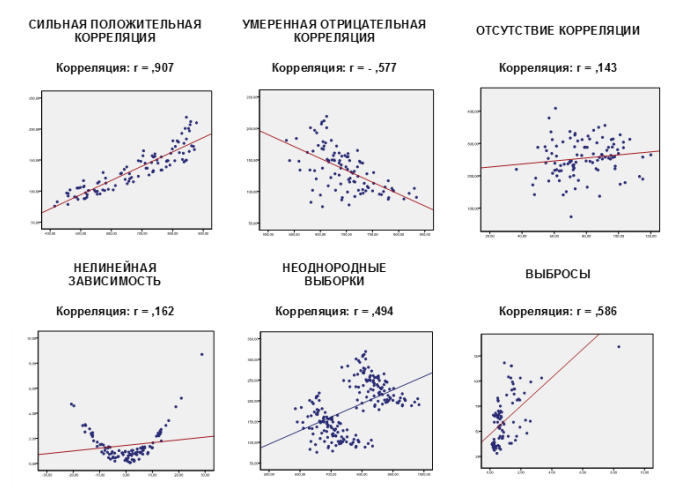

## Разбейте данные на выборки

Разобьём данные на 3 выборки: обучающую, валидационную и тестовую.

In [6]:
df_train, df_valid_test = train_test_split(df, test_size=0.25, random_state=12345)
df_valid, df_test = train_test_split(df_valid_test, test_size=0.5, random_state=12345)

Для каждой выборки разделим данные на целевой признак и матрицу признаков. Так как целью является определить тариф, то целевым признаком будет столбец `is_ultra`, а остальные - признаками.

In [7]:
features_train = df_train.drop(['is_ultra','calls'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra','calls'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra','calls'], axis=1)
target_test = df_test['is_ultra']

## Исследуйте модели

Рассмотрим 3 модели: decision tree, random forest, logistic regression.

### Decision Tree

In [8]:
model_dt = None
best_accuracy_dt = 0
best_depth_dt = 0

for depth in range(2, 51):
    
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    
    if accuracy > best_accuracy_dt:
        model_dt = model
        best_accuracy_dt = accuracy
        best_depth_dt = depth
    
print("Наилучшая глубина дерева:", best_depth_dt)
print("Точность:", best_accuracy_dt)

Наилучшая глубина дерева: 4
Точность: 0.8009950248756219


### Random Forest

In [9]:
model_rf = None
best_accuracy_rf = 0
best_est_rf = 0
best_depth_rf = 0

for est in range(2, 31):
    for depth in range(2, 21):
        
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        
        predictions_valid = model.predict(features_valid)
        accuracy = accuracy_score(target_valid, predictions_valid)
    
        if accuracy > best_accuracy_rf:
            model_rf = model
            best_accuracy_rf = accuracy
            best_est_rf = est
            best_depth_rf = depth
            
print("Количество деревьев:", best_est_rf)
print("Наилучшая глубина дерева:", best_depth_rf)
print("Точность:", best_accuracy_rf)

Количество деревьев: 20
Наилучшая глубина дерева: 14
Точность: 0.8258706467661692


### Logistic Regression

In [10]:
model_lr = LogisticRegression(random_state=12345) 
model_lr.fit(features_train, target_train) 
accuracy_lr = model.score(features_valid, target_valid) 

print("Точность:", accuracy_lr)

Точность: 0.7935323383084577


### Вывод

Все модели показали точность выше 75%. Лучшая точность - 82%, у случайного леса при 9 деревьях. Дерево решений показало точность 79.8%, и логистическая регрессия - 78.9%.

## Проверьте модель на тестовой выборке

Посмотрим, какая модель лучше всего себя проявит на тестовой выборке.

In [11]:
features = pd.concat([features_train, features_valid], ignore_index=True)
target = pd.concat([target_train, target_valid], ignore_index=True)

predictions_test_dt = model_dt.predict(features_test)
predictions_test_rf = model_rf.predict(features_test)
predictions_test_lr = model_lr.predict(features_test)

accuracy_dt = accuracy_score(target_test, predictions_test_dt)
accuracy_rf = accuracy_score(target_test, predictions_test_rf)
accuracy_lr = accuracy_score(target_test, predictions_test_lr)

print('Точность Decision Tree:', accuracy_dt)
print('Точность Random Forest:', accuracy_rf)
print('Точность Logistic Regression:', accuracy_lr)

Точность Decision Tree: 0.7910447761194029
Точность Random Forest: 0.7711442786069652
Точность Logistic Regression: 0.7039800995024875


### Вывод

Лучший результат показала модель Random Forest. Так же, хороший результат показала модель Decision Tree, а вот точность логистической прямой ниже 75%.

Если же выбирать наилучшую модель, то встаёт вопрос о скорости обработки. Не смотря на самый высокий показатель точности, Random Forest довольно таки медленно делает расчёты, Decision Tree гораздо быстрее, но имеет чуть меньшую точность.

## Проверка адекватности моделей

Проверим адекватность моделей с помощью Dummy Classifier.

In [12]:
dummy_results = []
dc = DummyClassifier(strategy = 'most_frequent', random_state = 42)
dc.fit(features, target)
result = dc.score(features_test, target_test)

print('Точность Dummy Classifier:', result)
print('Точность Decision Tree:', accuracy_dt)
print('Точность Random Forest:', accuracy_rf)
print('Точность Logistic Regression:', accuracy_lr)

Точность Dummy Classifier: 0.7039800995024875
Точность Decision Tree: 0.7910447761194029
Точность Random Forest: 0.7711442786069652
Точность Logistic Regression: 0.7039800995024875


Так как точность Decision Tree и Random Forest больше, чем у Dummy Classifier, то можно признать эти модели адекватными.